In [1]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(sf, warn.conflicts = FALSE)
library(vroom, warn.conflicts = FALSE)
library(tsibble, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(forcats, warn.conflicts = FALSE)
library(arrow, warn.conflicts = FALSE)
library(data.table, warn.conflicts = FALSE)
setDTthreads(7)
library(dtplyr, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(lubridate, warn.conflicts = FALSE)
source("src/paths/paths.R")
# source("src/load/load.R")
# source("src/pairing/utils.R")


Linking to GEOS 3.12.0, GDAL 3.7.3, PROJ 9.3.0; sf_use_s2() is TRUE



In [2]:
path.lom <- file.path(path.ds, "ARPA", "LOMBARDIA")
path.md <- file.path(path.lom, "Stazioni_Meteorologiche.tsv")

metadata <- fread(path.md, sep = "\t", colClasses = list(integer = c("IdSensore", "IdStazione"), character = c("Tipologia", "DataStart", "DataStop"), double = c("Quota", "lng", "lat"), factor = "Provincia")) |>
    filter(Tipologia == "Temperatura") |>
    select(!c(Tipologia, starts_with("UTM"), ends_with("Misura"), location, Storico)) |>
    mutate(DataStart = as.IDate(DataStart, format = "%d/%m/%Y"), DataStop = as.IDate(DataStop, format = "%d/%m/%Y"))


In [3]:
na_strings <- c("", "NA", "9999.0", "-9999.0", "-9999", "NV", "NC", "ND")

read_data.vroom <- function(file, ...) {
    vroom(
        file.path(path.lom, paste0(file, ".csv")),
        delim = ",",
        col_types = "icdfc",
        na = na_strings,
        ...
    )
}

read_data.fread <- function(file, ...) {
    fread(file.path(path.lom, paste0(file, ".csv")),
        sep = ",",
        colClasses = c(
            "IdSensore" = "integer",
            "Data" = "character",
            "Valore" = "double",
            "Stato" = "factor",
            "idOperatore" = "character"
        ),
        na.strings = na_strings,
        ...
    )
}

read_data.arrow <- function(file, ...) {
    read_csv_arrow(file.path(path.lom, paste0(file, ".csv")),
        schema = schema(
            IdSensore = uint32(),
            Data = timestamp(unit = "s"),
            Valore = float(),
            Stato = dictionary(),
            idOperatore = uint8()    
        ),
        timestamp_parsers = c("%d/%m/%Y %H:%M:%S", "%d/%m/%Y %H:%M:%S.000"),
        as_data_frame = FALSE,
        na = na_strings,
        col_names = TRUE,
        read_options = list(use_threads = TRUE, skip_rows = 0)
    )
}

load_data <- function(data, ...) {
    data |>
        semi_join(metadata, by = "IdSensore") |>
        # drop_na(Stato) |>
        mutate(Time = dmy_hms(Data), Variabile = fct(idOperatore, levels = c("2", "1", "3", "4")) |> fct_recode(..., PRECIP = "4"), .keep = "unused") |>
        arrange(IdSensore, Variabile, Time) |>
        mutate(Time = lag(Time), .by = c(IdSensore, Variabile)) |>
        # drop_na(Time) |>
        arrange(IdSensore, Time, Variabile)
}

compute_daily_stats <- function(data, extremes) {
    # if (extremes) {
    #     tmin <- "T_MIN"
    #     tmax <- "T_MAX"
    # } else {
    #     tmin <- "T_AVG"
    #     tmax <- "T_AVG"
    # }
    data |>
        # as_tsibble(key = IdSensore, index = Time) |>
        # group_by_key() |>
        # index_by(date = ~ lubridate::date(.)) |>
        group_by(IdSensore, date = lubridate::date(Time)) |>
        summarise(T_MIN = min(Valore, na.rm = TRUE), T_MAX = max(Valore, na.rm = TRUE), .groups = "drop_last")
}


In [4]:
l2013 <- read_data.vroom("2013") |> load_data()

In [5]:
l2013

IdSensore,Valore,Stato,Time,Variabile
<int>,<dbl>,<fct>,<dttm>,<fct>
115,-4.0,VA,2013-01-01 00:00:00,1
115,-4.1,VA,2013-01-01 00:10:00,1
115,-4.1,VA,2013-01-01 00:20:00,1
115,-4.0,VA,2013-01-01 00:30:00,1
115,-3.9,VA,2013-01-01 00:40:00,1
115,-3.8,VA,2013-01-01 00:50:00,1
115,-3.9,VA,2013-01-01 01:00:00,1
115,-4.1,VA,2013-01-01 01:10:00,1
115,-4.0,VA,2013-01-01 01:20:00,1


In [21]:
# there are problems in 2012.csv but they are not relevant.
#  stats1 <- load_data(c("METEO_2001-2005", "2008", "2010", "2012"), T_AVG = "1", T_MIN = "2", T_MAX = "3") |> compute_daily_stats(FALSE)
#  write_parquet(stats1, file.path(path.lom, "lom2012.parquet"))
#  gc()
stats1 <- read_parquet(file.path(path.lom, "lom2012.parquet"))


In [23]:
nrow(stats1) / 11


[1] 55811.82

In [5]:
#  stats2 <- load_data(seq(2012, 2016) |> as.character(), T_AVG = "1", T_MIN = "2", T_MAX = "3") |> compute_daily_stats(FALSE)
#  write_parquet(stats2, file.path(path.lom, "lom11-16.parquet"))
#  gc()
stats2 <- read_parquet(file.path(path.lom, "lom11-16.parquet"))


In [6]:
#  merged <- bind_rows(
#      stats1 |> as_tibble(),
#      stats2 |> as_tibble(),
#  ) |> group_by(IdSensore, date) |> summarise(across(starts_with("T"), last), .groups = "drop") |> as_tsibble(key = IdSensore, index = date)
#  write_parquet(merged, file.path(path.lom, "all_lom2016.parquet"))
lom2016 <- read_parquet(file.path(path.lom, "all_lom2016.parquet"))


In [19]:
l2016 <- load_data("2016", T_AVG = "1", .n_max = Inf) |> compute_daily_stats()


In [20]:
l2016


IdSensore,date,T_MIN,T_MAX
<int>,<date>,<dbl>,<dbl>
115,2016-01-01,-3.5,4.3
115,2016-01-02,-3.5,0.1
115,2016-01-03,-5.0,1.3
115,2016-01-04,-5.8,-3.2
115,2016-01-05,-6.9,-0.9
115,2016-01-06,-7.2,-3.2
115,2016-01-07,-6.6,-1.6
115,2016-01-08,-4.1,3.7
115,2016-01-09,-1.0,1.6


In [5]:
library(tsbox)


In [10]:
l2016 |> ts_tsibble()


Found numeric [id] column(s): 'IdSensore'.
Are you using a wide data frame? To convert, use 'ts_long()'.
Convert column(s) to character or factor to silence this message.


[time]: 'Time' [value]: 'Valore' 



IdSensore,Valore,Stato,Time,Variabile
<int>,<dbl>,<fct>,<dttm>,<fct>
115,0.0,VA,2016-01-01 00:00:00,T_AVG
115,0.2,VA,2016-01-01 00:10:00,T_AVG
115,0.3,VA,2016-01-01 00:20:00,T_AVG
115,0.4,VA,2016-01-01 00:30:00,T_AVG
115,0.5,VA,2016-01-01 00:40:00,T_AVG
115,0.3,VA,2016-01-01 00:50:00,T_AVG
115,0.1,VA,2016-01-01 01:00:00,T_AVG
115,-0.1,VA,2016-01-01 01:10:00,T_AVG
115,0.0,VA,2016-01-01 01:20:00,T_AVG


In [5]:
l2016 |> compute_daily_stats()


IdSensore,date,T_MIN,T_MAX
<int>,<date>,<dbl>,<dbl>
115,2016-01-01,-3.5,4.3
115,2016-01-02,-3.5,0.1
115,2016-01-03,-5.0,1.3
115,2016-01-04,-5.2,-4.4
2001,2016-01-01,-1.4,6.3
2001,2016-01-02,0.2,2.3
2001,2016-01-03,-0.1,2.8
2001,2016-01-04,0.6,2.0
2039,2016-01-01,-0.8,2.9


In [16]:
l2017 <- load_data.table("2017", T_MIN = "1", T_MAX = "3")


In [17]:
l2017


IdSensore,Time,T_MIN,T_MAX
<int>,<dttm>,<dbl>,<dbl>
115,2017-01-01 00:00:00,-0.6,NA
115,2017-01-01 00:10:00,-0.6,NA
115,2017-01-01 00:20:00,-0.6,NA
115,2017-01-01 00:30:00,-0.7,NA
115,2017-01-01 00:40:00,-0.8,NA
115,2017-01-01 00:50:00,-0.6,NA
115,2017-01-01 01:00:00,-0.7,NA
115,2017-01-01 01:10:00,-0.7,NA
115,2017-01-01 01:20:00,-0.4,NA


In [69]:
l2018 <- load_data("2018", .n_max = Inf)


In [70]:
l2018


IdSensore,Data,1,3,2
<int>,<dttm>,<dbl>,<dbl>,<dbl>
53,2018-08-23 13:10:00,16.9,NA,NA
53,2018-08-23 13:20:00,16.9,NA,NA
53,2018-08-23 13:30:00,16.6,NA,NA
53,2018-08-23 13:40:00,15.9,NA,NA
53,2018-08-23 13:50:00,15.1,NA,NA
53,2018-08-23 14:00:00,14.5,NA,NA
53,2018-08-23 14:10:00,14.4,NA,NA
53,2018-08-23 14:20:00,14.6,NA,NA
53,2018-08-23 14:30:00,14.5,NA,NA


In [47]:
a <- vroom(file.path(path.lom, "2017.csv"),
    delim = ",",
    col_types = cols(
        IdSensore = col_integer(),
        Data = col_datetime("%d/%m/%Y %H:%M:%S"),
        Valore = col_double(),
        Stato = col_factor(),
        idOperatore = col_factor(levels = c("1", "2", "3", "4"))
    ),
    na = c("", "NA", "9999.0", "-9999.0", "-9999", "NV", "NC", "ND")
)


In [48]:
b <- a |> semi_join(metadata, by = "IdSensore")


In [65]:
b |>
    drop_na(Stato) |>
    mutate(Variabile = fct_recode(idOperatore, T_AVG = "1", T_MIN = "2", T_MAX = "3", PRECIP = "4"), .keep = "unused") |>
    pivot_wider(names_from = Variabile, values_from = Valore, id_cols = c(IdSensore, Data))


IdSensore,Data,T_AVG,T_MAX
<int>,<dttm>,<dbl>,<dbl>
10377,2017-01-01,1.4,NA
10551,2017-01-01,-2.6,NA
10570,2017-01-01,1.1,NA
11007,2017-01-01,-0.4,NA
11044,2017-01-01,-4.2,NA
14014,2017-01-01,2.5,NA
14058,2017-01-01,4.3,NA
14075,2017-01-01,3.6,NA
14092,2017-01-01,4.3,NA


In [26]:
metadata |> filter(IdSensore == 2001)


IdSensore,IdStazione,NomeStazione,Quota,Provincia,DataStart,DataStop,lng,lat
<int>,<int>,<chr>,<dbl>,<fct>,<date>,<date>,<dbl>,<dbl>
2001,100,Milano Lambrate,120,MI,2001-06-29,NA,9.257515,45.49678


In [24]:
a


IdSensore,Data,Valore,Stato,idOperatore
<dbl>,<chr>,<dbl>,<chr>,<dbl>
2001,01/01/2018 00:00:00,3.5,VA,1
2002,01/01/2018 00:00:00,99.0,VA,1
2006,01/01/2018 00:00:00,0.0,VA,4
2008,01/01/2018 00:00:00,0.0,VA,1
2039,01/01/2018 00:00:00,3.2,VA,1
2040,01/01/2018 00:00:00,99.0,VA,1
2044,01/01/2018 00:00:00,0.0,VA,1
2046,01/01/2018 00:00:00,0.0,VA,4
2082,01/01/2018 00:00:00,0.4,VA,1


In [22]:
l2018 |> distinct(IdSensore)


IdSensore
<int>
19293


In [ ]:
stats2 <- load_data(seq(2012, 20))


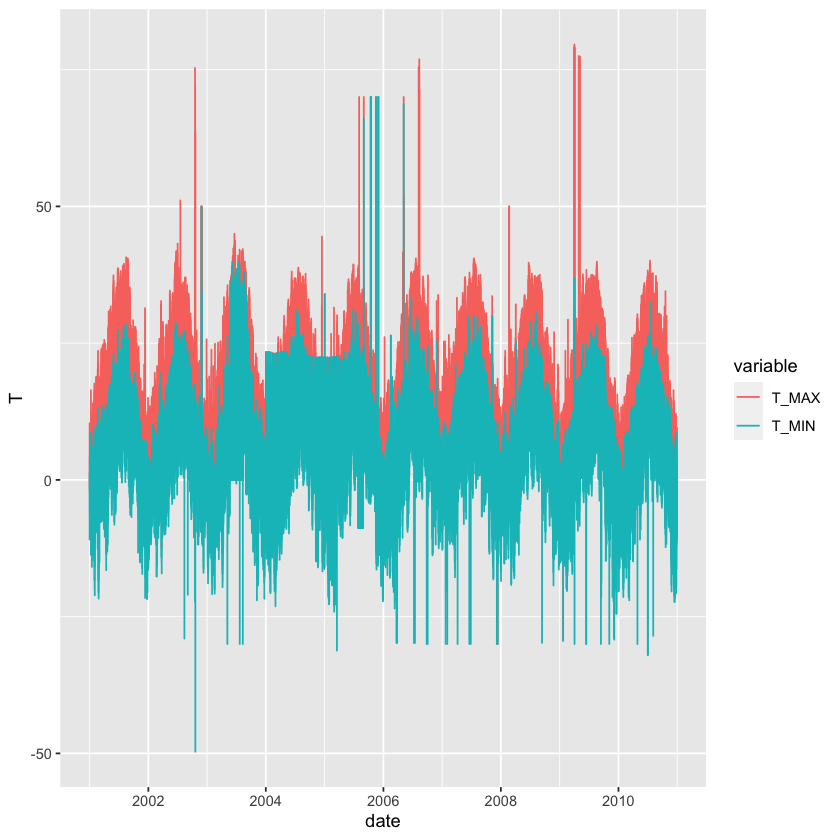

In [17]:
library(ggplot2)
ggplot(stats |> pivot_longer(c(T_MIN, T_MAX), values_to = "T", names_to = "variable")) +
    geom_line(aes(date, T, color = variable))


In [29]:
load_data("2018", n_max = Inf)


IdSensore,Data,T_AVG,T_MAX,T_MIN
<int>,<dttm>,<dbl>,<dbl>,<dbl>
19293,2018-05-08 14:00:00,22.6,23.3,21.9
19293,2018-05-08 14:10:00,22.5,23.1,21.7
19293,2018-05-08 14:20:00,21.7,22.1,21.4
19293,2018-05-08 14:30:00,22.2,22.8,21.7
19293,2018-05-08 14:40:00,21.8,22.1,21.4
19293,2018-05-08 14:50:00,21.4,22.1,21.1
19293,2018-05-08 15:00:00,21.8,22.5,21.2
19293,2018-05-08 15:10:00,20.8,21.1,20.4
19293,2018-05-08 15:20:00,20.3,20.5,20.1
